In [1]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip \
    -O /tmp/horse-or-human.zip

--2019-11-04 12:23:34--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.169.240, 2a00:1450:4018:801::2010
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.169.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149574867 (143M) [application/zip]
Saving to: ‘/tmp/horse-or-human.zip’

/tmp/horse-or-human 100%[===================>] 142.65M  1.47MB/s    in 92s     

2019-11-04 12:25:08 (1.55 MB/s) - ‘/tmp/horse-or-human.zip’ saved [149574867/149574867]



In [2]:
import os 
import zipfile 

local_zip = "/tmp/horse-or-human.zip" # zip directory Address
zip_ref = zipfile.ZipFile(local_zip, 'r') # zip reference / "r" to read from the directory
zip_ref.extractall('/tmp/horse-or-human')
zip_ref.close()

# The contents of the zip directory are extracted in base directory /tmp/horse-or-human
# This in turn contains "horses" and "humans" subdirectories

In [4]:
# Directory with our training horse pictures
train_horse_dir = os.path.join('/tmp/horse-or-human/horses')

# Directory with our training human pictures
train_human_dir = os.path.join('/tmp/horse-or-human/humans')

# Let's see how the filenames looks like in humans and horses training directories
train_human_names = os.listdir(train_human_dir)
print(train_human_names[:10])

print('\n')
train_horse_names = os.listdir(train_horse_dir)
print(train_horse_names[:10])


['human07-28.png', 'human06-20.png', 'human04-15.png', 'human03-12.png', 'human05-01.png', 'human01-22.png', 'human07-15.png', 'human01-10.png', 'human09-16.png', 'human05-19.png']


['horse29-7.png', 'horse49-5.png', 'horse25-8.png', 'horse27-7.png', 'horse25-6.png', 'horse04-8.png', 'horse15-4.png', 'horse50-2.png', 'horse28-6.png', 'horse22-6.png']


In [5]:
# Total number of horse and human images
print('Total training horse images: ', len(os.listdir(train_horse_dir)))
print('Total trainin human images: ', len(os.listdir(train_human_dir)))

Total training horse images:  500
Total trainin human images:  527


Now let's go ahead and take a look at a few pictures, to get a better sense of what they look like. First let's configure the __Matplotlib__ parameters.

In [6]:
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg

%matplotlib inline 

# we'll output our image in 4*4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

Now display the batch of 8 __Horse__ and 8 __Human__ pictures. We can rerun the cell to see a fresh batch each time. 

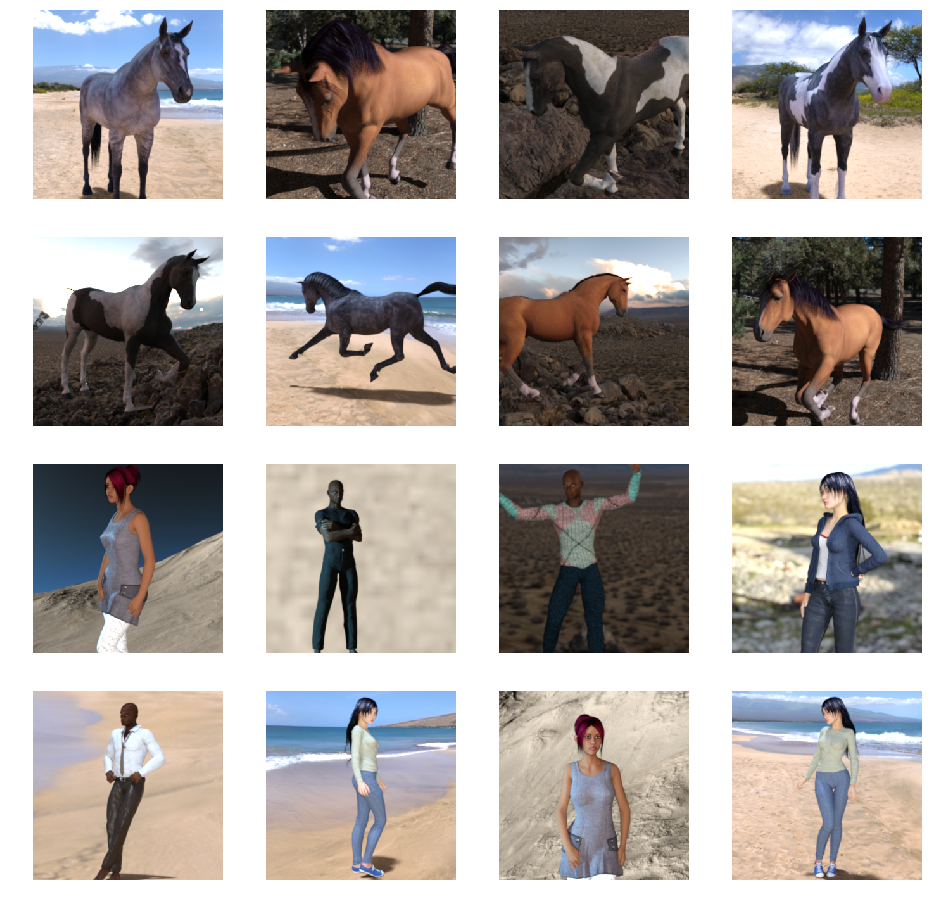

In [7]:
# set up matplotlib fig, and size it to fit 4*4 pics
fig = plt.gcf() # Get the current figure.
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_horse_pix = [os.path.join(train_horse_dir, fname)
                  for fname in train_horse_names[pic_index-8: pic_index]]

next_human_pix = [os.path.join(train_human_dir, fname)
                  for fname in train_human_names[pic_index-8: pic_index]]

for i, img_path in enumerate(next_horse_pix + next_human_pix):
    # setup subplot; subplot indeces start at 1
    sb = plt.subplot(nrows, ncols, i+1)
    sb.axis("off")
    
    img = mpimg.imread(img_path)
    plt.imshow(img)
    
plt.show()

## Building a Smooth Model from Scratch:

In [24]:
import tensorflow as tf 
import warnings
warnings.filterwarnings("ignore")
print(tf.__version__)


1.13.1


In [20]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 300x300 with 3 bytes color
    # first convolution layer
    tf.keras.layers.Conv2D(16, (3,3), activation = 'relu', input_shape = (300, 300, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    # second convolution layer
    tf.keras.layers.Conv2D(32, (3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # third convolution layer
    tf.keras.layers.Conv2D(64, (3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # fourth convolution layer 
    tf.keras.layers.Conv2D(64, (3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # fifth convolution layer 
    tf.keras.layers.Conv2D(64, (3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten layer: Flatten the 
    tf.keras.layers.Flatten(),
    # add dense layer with 512 number of neurons
    tf.keras.layers.Dense(512, activation = 'relu'),
    # finally add another dense layer with only single Neuron for Binary classificaton
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_35 (Conv2D)           (None, 298, 298, 16)      448       
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 147, 147, 32)      4640      
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 33, 33, 64)        36928     
__________

## Compiling the Model:

In [21]:
model.compile(loss = 'binary_crossentropy', 
             optimizer = tf.keras.optimizers.RMSprop(lr = 0.001),
             metrics = ['acc'])

# here we have chosen "RMSprop" as an optimizer, because it automates learing_rate
# tunning for us. Other optimizers such as "Adam" and "Adagrad" also automatically adapt
# the learning_rate and would work equally well here!

## Data Pre-Processing:

### Use of Tensorflow Image Generator:

Let's set-up the __Data Generators__ that will do the following things for us:
* Read pictures from our source folder
* Convert them to float32 tensor
* Feed them with their labels to our Dense Neural Network

We'll have one generator for the training and one for the validation images. Our generator will yield batches of images of size __300x300__ and their __labels__ (binary). First we'll process the data by normalizing pixels values from __[0,1]__ range, originally the values are in __[0,255]__ range. 

In [39]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1/255
train_datagen = ImageDataGenerator(rescale = 1/255)
validation_datagen = ImageDataGenerator(rescale = 1/255)
# ImageDataGenerator -> Generates batches of tensor image data with real-time data augmentation

# Flow training images in batches of 128 using train_datagen generator 
train_generator = train_datagen.flow_from_directory(
    '/tmp/horse-or-human/', # source directory for training images 
    target_size = (300, 300), # all images will be resized to 
    batch_size = 128,
    class_mode = 'binary', # since we use binary_crossentropy loss, so we need binary labels
)

Found 1027 images belonging to 2 classes.


## Training the Model:

In [27]:
history = model.fit(
    train_generator,
    steps_per_epoch = 8,
    epochs = 8,
    verbose = 1,
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/8
9/9 [==============================] - 100s 11s/step - loss: 0.8441 - acc: 0.5998
Epoch 2/8
9/9 [==============================] - 102s 11s/step - loss: 0.6474 - acc: 0.7215
Epoch 3/8
9/9 [==============================] - 102s 11s/step - loss: 0.6348 - acc: 0.7449
Epoch 4/8
9/9 [==============================] - 96s 11s/step - loss: 0.5258 - acc: 0.8315
Epoch 5/8
9/9 [==============================] - 96s 11s/step - loss: 0.1867 - acc: 0.9396
Epoch 6/8
9/9 [==============================] - 104s 12s/step - loss: 0.2287 - acc: 0.9153
Epoch 7/8
9/9 [==============================] - 88s 10s/step - loss: 0.0598 - acc: 0.9776
Epoch 8/8
9/9 [==============================] - 92s 10s/step - loss: 0.2886 - acc: 0.8919
